In [1]:
# Imports
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from ml4cvd.defines import StorageType
from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4cvd.recipes import test_multimodal_multitask, train_multimodal_multitask, saliency_maps

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# Paths
HD5_FOLDER = './mnist_hd5s/'
OUTPUT_FOLDER = './runs/'

In [3]:
def load_data(dataset):
    ''' Loads the dataset
    :param dataset: the path to the dataset (here MNIST)'''
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    return train_set, valid_set, test_set

In [4]:
def plot_mnist(sides):
    train, _, _ = load_data('mnist.pkl.gz')
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    sides = int(np.ceil(np.sqrt(min(sides, mnist_images.shape[0]))))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i in range(sides*sides):
        axes[i // sides, i % sides].imshow(mnist_images[i, ..., 0], cmap='gray')
        axes[i // sides, i % sides].set_xticks(())
        axes[i // sides, i % sides].set_yticks(())

loading data...
(50000, 784)


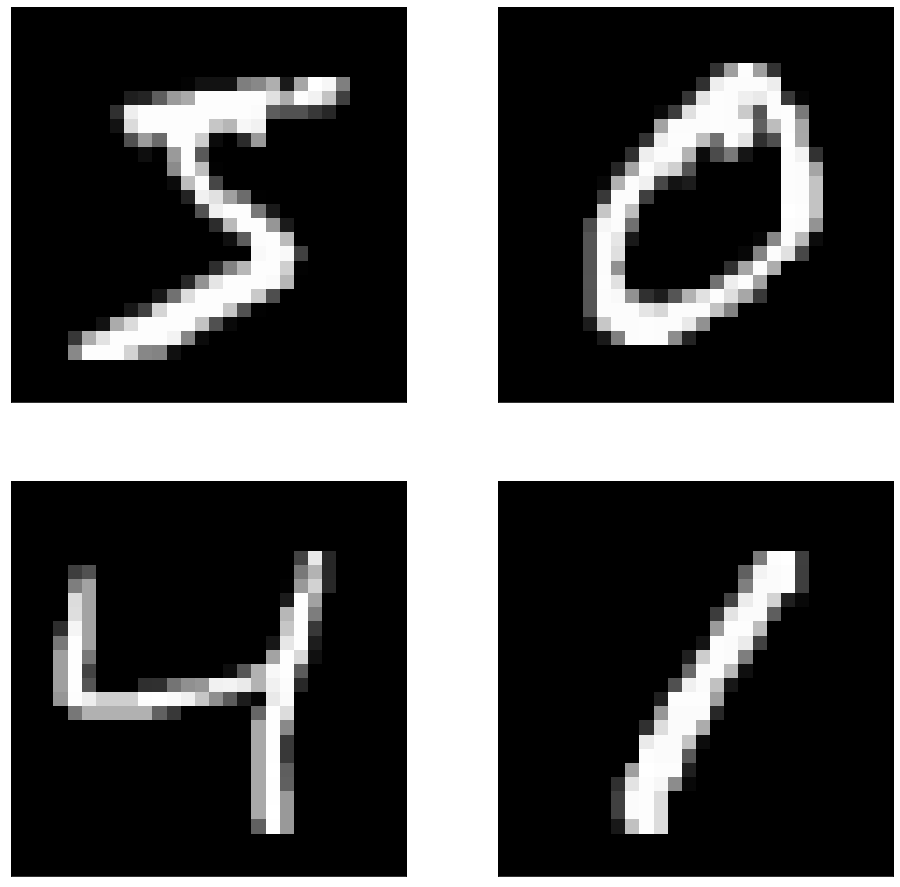

In [5]:
plot_mnist(4)

loading data...
(50000, 784)


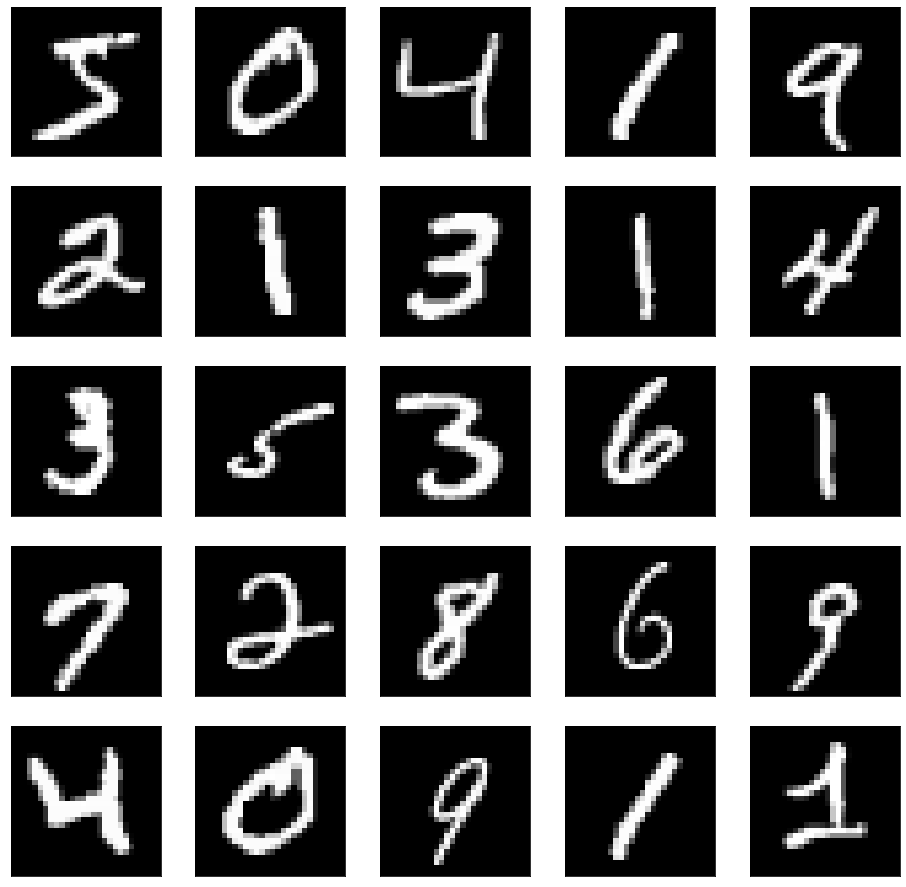

In [6]:
plot_mnist(25)

## Tensorization
It is often helpful to separate data preparation from model training.  In ML4CVD we call the final data preparation process tensorization.  Tensorization involves gathering all input files (XMLS, CSVs, DICOMs, PNGs, etc) and consolidating them into compressed HD5 files.  We tend to make one HD5 file per individual in the cohort we are studying.  The files contain the raw data and labels (inputs and outputs) we will use to train models.

In [7]:
def mnist_as_hd5(hd5_folder):
    train, _, _ = load_data('mnist.pkl.gz')
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)
    for i, mnist_image in enumerate(mnist_images):
        with h5py.File(os.path.join(hd5_folder, f'{i}.hd5'), 'w') as hd5:
            hd5.create_dataset('mnist_image', data=mnist_image)
            hd5.create_dataset('mnist_label', data=[train[1][i]])
        if (i+1) % 5000 == 0:
            print(f'Wrote {i+1} MNIST images and labels as HD5 files')

In [8]:
mnist_as_hd5(HD5_FOLDER)

loading data...
Wrote 5000 MNIST images and labels as HD5 files
Wrote 10000 MNIST images and labels as HD5 files
Wrote 15000 MNIST images and labels as HD5 files
Wrote 20000 MNIST images and labels as HD5 files
Wrote 25000 MNIST images and labels as HD5 files
Wrote 30000 MNIST images and labels as HD5 files
Wrote 35000 MNIST images and labels as HD5 files
Wrote 40000 MNIST images and labels as HD5 files
Wrote 45000 MNIST images and labels as HD5 files
Wrote 50000 MNIST images and labels as HD5 files


## TensorMaps
The central data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to construct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.  The most important method of each TensorMap is their ***tensor_from_file*** function.  This callback function takes the TensorMap, an HD5 file handle, and an optional dictionary as input arguments and it returns a numpy array.

In [9]:
def mnist_image_from_hd5(tm, hd5, dependents={}):
     return np.array(hd5['mnist_image'])

def mnist_label_from_hd5(tm, hd5, dependents={}):
    one_hot = np.zeros(tm.shape, dtype=np.float32)
    one_hot[int(hd5['mnist_label'][0])] = 1.0
    return one_hot
    
TMAPS['mnist_image'] = TensorMap('mnist_image', shape=(28, 28, 1), tensor_from_file=mnist_image_from_hd5)
TMAPS['mnist_label'] = TensorMap('mnist_label', Interpretation.CATEGORICAL, tensor_from_file=mnist_label_from_hd5,
                                 channel_map={f'digit_{i}': i for i in range(10)})


## Command Line Friendly Jupyter Notebooks
By directly setting the `sys.argv` array in our jupyter notebooks we make the process of translating from notebook to command line straightforward.  For example, the cell below can be replicated on the command line by running:
```
./scripts/tf.sh $HOME/ml/ml4cvd/recipes.py --mode train --tensors ./mnist_hd5s/ \
    --input_tensors mnist_image --output_tensors mnist_label \
    --batch_size 64 --test_steps 64 --epochs 24 \
    --output_folder ./runs/ --id learn_mnist
```
The script `tf.sh` starts the appropriate docker container and then calls python on the provided arguments.


In [10]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_label',
            '--batch_size', '64',
            '--test_steps', '64',
            '--epochs', '24',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'learn_mnist'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-06-08 11:56:40,303 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./runs/learn_mnist/log_2020-06-08_11-56_0.log.
2020-06-08 11:56:40,304 - arguments:375 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_label --batch_size 64 --test_steps 64 --epochs 24 --output_folder ./runs/ --id learn_mnist

2020-06-08 11:56:40,305 - arguments:376 - INFO - Total TensorMaps: 580 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=64, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size=875000000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuo

2020-06-08 11:56:44,204 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-06-08 11:56:44,548 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 400 steps, validate for 40 steps
Epoch 1/24
399/400 [============================>.] - ETA: 0s - loss: 1.4697 - categorical_accuracy: 0.4858 - digit_0_precision: 0.4724 - digit_1_precision: 0.4924 - digit_2_precision: 0.5212 - digit_3_precision: 0.4193 - digit_4_precision: 0.3253 - digit_5_precision: 0.2164 - digit_6_precision: 0.4835 - digit_7_precision: 0.3427 - digit_8_precision: 0.3123 - digit_9_precision: 0.3252 - digit_0_recall: 0.3997 - digit_1_recall: 0.4449 - digit_2_recall: 0.3913 - digit_3_recall: 0.3063 - digit_4_recall: 0.2758 - digit_5_recall: 0.1151 - digit_6_recall: 0.4251 - digit_7_recall: 0.2495 - digit_8_recall: 0.1921 - digit_9_recall: 0.2464             - ETA: 7s - loss: 1.8231 - categorical_accuracy: 0.3534 - digit_0_precision: 0.2803 - digi

Epoch 4/24
399/400 [============================>.] - ETA: 0s - loss: 0.1472 - categorical_accuracy: 0.9582 - digit_0_precision: 0.9775 - digit_1_precision: 0.9856 - digit_2_precision: 0.9611 - digit_3_precision: 0.9639 - digit_4_precision: 0.9576 - digit_5_precision: 0.9632 - digit_6_precision: 0.9706 - digit_7_precision: 0.9645 - digit_8_precision: 0.9506 - digit_9_precision: 0.9384 - digit_0_recall: 0.9693 - digit_1_recall: 0.9783 - digit_2_recall: 0.9411 - digit_3_recall: 0.9342 - digit_4_recall: 0.9475 - digit_5_recall: 0.9505 - digit_6_recall: 0.9713 - digit_7_recall: 0.9515 - digit_8_recall: 0.9245 - digit_9_recall: 0.9245
Epoch 00004: val_loss improved from 0.15678 to 0.14056, saving model to ./runs/learn_mnist/learn_mnist.h5
400/400 [==============================] - 13s 32ms/step - loss: 0.1471 - categorical_accuracy: 0.9582 - digit_0_precision: 0.9776 - digit_1_precision: 0.9856 - digit_2_precision: 0.9612 - digit_3_precision: 0.9640 - digit_4_precision: 0.9574 - digit_5_pre

Epoch 7/24
325/400 [=======================>......] - ETA: 2s - loss: 0.0894 - categorical_accuracy: 0.9724 - digit_0_precision: 0.9864 - digit_1_precision: 0.9887 - digit_2_precision: 0.9752 - digit_3_precision: 0.9827 - digit_4_precision: 0.9762 - digit_5_precision: 0.9694 - digit_6_precision: 0.9803 - digit_7_precision: 0.9749 - digit_8_precision: 0.9643 - digit_9_precision: 0.9589 - digit_0_recall: 0.9806 - digit_1_recall: 0.9831 - digit_2_recall: 0.9678 - digit_3_recall: 0.9625 - digit_4_recall: 0.9679 - digit_5_recall: 0.9621 - digit_6_recall: 0.9797 - digit_7_recall: 0.9670 - digit_8_recall: 0.9447 - digit_9_recall: 0.95562020-06-08 11:58:26,339 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ train_worker completed true epoch 5 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 34927 paths. Epoch: 5
	6985 tensors were presented.
	0 paths were skipped because they previously failed.
	The following errors occurred:
		
399/400 [========================

Epoch 10/24
213/400 [==============>...............] - ETA: 5s - loss: 0.0652 - categorical_accuracy: 0.9800 - digit_0_precision: 0.9918 - digit_1_precision: 0.9862 - digit_2_precision: 0.9717 - digit_3_precision: 0.9851 - digit_4_precision: 0.9832 - digit_5_precision: 0.9839 - digit_6_precision: 0.9840 - digit_7_precision: 0.9823 - digit_8_precision: 0.9723 - digit_9_precision: 0.9793 - digit_0_recall: 0.9885 - digit_1_recall: 0.9821 - digit_2_recall: 0.9644 - digit_3_recall: 0.9688 - digit_4_recall: 0.9789 - digit_5_recall: 0.9793 - digit_6_recall: 0.9821 - digit_7_recall: 0.9833 - digit_8_recall: 0.9652 - digit_9_recall: 0.97422020-06-08 11:59:01,295 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ train_worker completed true epoch 7 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 34927 paths. Epoch: 7
	4990 tensors were presented.
	0 paths were skipped because they previously failed.
	The following errors occurred:
		
399/400 [=======================

Epoch 13/24
105/400 [======>.......................] - ETA: 9s - loss: 0.0314 - categorical_accuracy: 0.9914 - digit_0_precision: 0.9926 - digit_1_precision: 0.9949 - digit_2_precision: 0.9929 - digit_3_precision: 0.9970 - digit_4_precision: 0.9922 - digit_5_precision: 0.9913 - digit_6_precision: 0.9927 - digit_7_precision: 0.9902 - digit_8_precision: 0.9859 - digit_9_precision: 0.9930 - digit_0_recall: 0.9943 - digit_1_recall: 0.9965 - digit_2_recall: 0.9946 - digit_3_recall: 0.9891 - digit_4_recall: 0.9899 - digit_5_recall: 0.9906 - digit_6_recall: 0.9948 - digit_7_recall: 0.9944 - digit_8_recall: 0.9779 - digit_9_recall: 0.98442020-06-08 11:59:36,661 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ train_worker completed true epoch 9 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 34927 paths. Epoch: 9
	3881 tensors were presented.
	0 paths were skipped because they previously failed.
	The following errors occurred:
		
399/400 [=======================

Epoch 16/24
399/400 [============================>.] - ETA: 0s - loss: 0.0330 - categorical_accuracy: 0.9895 - digit_0_precision: 0.9953 - digit_1_precision: 0.9926 - digit_2_precision: 0.9897 - digit_3_precision: 0.9945 - digit_4_precision: 0.9931 - digit_5_precision: 0.9823 - digit_6_precision: 0.9920 - digit_7_precision: 0.9864 - digit_8_precision: 0.9861 - digit_9_precision: 0.9820 - digit_0_recall: 0.9934 - digit_1_recall: 0.9915 - digit_2_recall: 0.9870 - digit_3_recall: 0.9890 - digit_4_recall: 0.9897 - digit_5_recall: 0.9797 - digit_6_recall: 0.9926 - digit_7_recall: 0.9884 - digit_8_recall: 0.9823 - digit_9_recall: 0.9795
Epoch 00016: val_loss did not improve from 0.04809
400/400 [==============================] - 13s 32ms/step - loss: 0.0329 - categorical_accuracy: 0.9895 - digit_0_precision: 0.9953 - digit_1_precision: 0.9926 - digit_2_precision: 0.9897 - digit_3_precision: 0.9945 - digit_4_precision: 0.9931 - digit_5_precision: 0.9823 - digit_6_precision: 0.9920 - digit_7_p

399/400 [============================>.] - ETA: 0s - loss: 0.0262 - categorical_accuracy: 0.9920 - digit_0_precision: 0.9944 - digit_1_precision: 0.9932 - digit_2_precision: 0.9931 - digit_3_precision: 0.9931 - digit_4_precision: 0.9929 - digit_5_precision: 0.9849 - digit_6_precision: 0.9926 - digit_7_precision: 0.9931 - digit_8_precision: 0.9900 - digit_9_precision: 0.9884 - digit_0_recall: 0.9930 - digit_1_recall: 0.9940 - digit_2_recall: 0.9916 - digit_3_recall: 0.9881 - digit_4_recall: 0.9907 - digit_5_recall: 0.9831 - digit_6_recall: 0.9905 - digit_7_recall: 0.9931 - digit_8_recall: 0.9837 - digit_9_recall: 0.98912020-06-08 12:01:02,602 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ validation_worker completed true epoch 5 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 10085 paths. Epoch: 5
	2017 tensors were presented.
	0 paths were skipped because they previously failed.
	The following errors occurred:
		

Epoch 00019: val_loss did not improve 

Epoch 22/24
325/400 [=======================>......] - ETA: 2s - loss: 0.0182 - categorical_accuracy: 0.9944 - digit_0_precision: 0.9977 - digit_1_precision: 0.9968 - digit_2_precision: 0.9950 - digit_3_precision: 0.9958 - digit_4_precision: 0.9895 - digit_5_precision: 0.9956 - digit_6_precision: 0.9956 - digit_7_precision: 0.9843 - digit_8_precision: 0.9893 - digit_9_precision: 0.9929 - digit_0_recall: 0.9973 - digit_1_recall: 0.9958 - digit_2_recall: 0.9904 - digit_3_recall: 0.9939 - digit_4_recall: 0.9921 - digit_5_recall: 0.9937 - digit_6_recall: 0.9958 - digit_7_recall: 0.9832 - digit_8_recall: 0.9884 - digit_9_recall: 0.98742020-06-08 12:01:38,468 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ train_worker completed true epoch 16 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 34927 paths. Epoch: 16
	2183 tensors were presented.
	0 paths were skipped because they previously failed.
	The following errors occurred:
		
399/400 [=====================

2020-06-08 12:02:06,745 - tensor_generators:213 - INFO - Stopped 4 workers.
2020-06-08 12:02:06,747 - tensor_generators:213 - INFO - Stopped 2 workers.
2020-06-08 12:02:06,752 - models:1058 - INFO - Model weights saved at: ./runs/learn_mnist/learn_mnist.h5
2020-06-08 12:02:12,466 - plots:213 - INFO - Saved learning curves at:./runs/learn_mnist/metric_history_learn_mnist.png
2020-06-08 12:02:12,578 - tensor_generators:149 - INFO - Started 3 test workers with cache size 0.0GB.
2020-06-08 12:02:14,347 - tensor_generators:472 - INFO - Made a big batch of tensors with key:input_mnist_image_continuous and shape:(4096, 28, 28, 1).
2020-06-08 12:02:14,349 - tensor_generators:472 - INFO - Made a big batch of tensors with key:output_mnist_label_categorical and shape:(4096, 10).
2020-06-08 12:02:14,630 - tensor_generators:403 - WARNING - Test worker test_worker_0 completed a full epoch. Test results may be double counting samples.
2020-06-08 12:02:14,754 - tensor_generators:403 - WARNING - Test w

{'digit_0': 0.9999794629199479,
 'digit_1': 0.9998291940200653,
 'digit_2': 0.9996374704175246,
 'digit_3': 0.9999448944729157,
 'digit_4': 0.9998681535631326,
 'digit_5': 0.9998059600022662,
 'digit_6': 0.9999325844073863,
 'digit_7': 0.9998891329276517,
 'digit_8': 0.9998407556647645,
 'digit_9': 0.9997728927867573}

<Figure size 2880x2880 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x1152 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 2304x2304 with 0 Axes>

## Evaluating ML Models in ML4CVD
Each ML4CVD training run creates several plots to give insight into model performance and learning dynamics.  The plots created will depend on the TensorMaps used but in general will include a metric history showing learning curves of each metric tracked during training, performance plots like ROC and Precision Recall curves for classifiers or scatter plots for regressors, calibration plots, and a t-SNE plot showing a 2D representation of the learned embedding of the trained model.
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/metric_history_learn_mnist.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/precision_recall_mnist_label.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/per_class_roc_mnist_label.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/calibrations_mnist_label.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/tsne_plot.png)

## Survival Analysis

In [11]:
def mnist_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    tensor[0] = 1.0 if np.random.rand() > (label / 10) else 0.0
    tensor[1] = np.random.randint(1, 3650)
    return tensor
    
TMAPS['mnist_time_to_event'] = TensorMap('mnist_time_to_event', Interpretation.TIME_TO_EVENT, 
                                         tensor_from_file=mnist_label_as_time_to_event)

2020-06-08 12:03:07,415 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./runs/mnist_time_to_event/log_2020-06-08_12-03_0.log.
2020-06-08 12:03:07,416 - arguments:375 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_time_to_event --training_steps 64 --validation_steps 24 --test_steps 30 --batch_size 32 --epochs 1 --eager --output_folder ./runs/ --id mnist_time_to_event

2020-06-08 12:03:07,417 - arguments:376 - INFO - Total TensorMaps: 581 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size=875000000.0, categori

2020-06-08 12:03:11,780 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-06-08 12:03:11,987 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 64 steps, validate for 24 steps
63/64 [============================>.] - ETA: 0s - loss: 1.4083
Epoch 00001: val_loss improved from inf to 1.39028, saving model to ./runs/mnist_time_to_event/mnist_time_to_event.h5
64/64 [==============================] - 11s 179ms/step - loss: 1.4124 - val_loss: 1.3903
2020-06-08 12:03:23,595 - tensor_generators:213 - INFO - Stopped 4 workers.
2020-06-08 12:03:23,596 - tensor_generators:213 - INFO - Stopped 2 workers.
2020-06-08 12:03:23,597 - models:1058 - INFO - Model weights saved at: ./runs/mnist_time_to_event/mnist_time_to_event.h5
2020-06-08 12:03:24,492 - plots:213 - INFO - Saved learning curves at:./runs/mnist_time_to_event/metric_history_mnist_time_to_event.png
2020-06-08 12:03:24,614 - tensor_generators:149 - INFO - Sta

{'mnist_time_to_event_C_Index_0.551_vs_ROC': 0.6336142678008905}

<Figure size 1152x1152 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x1152 with 0 Axes>

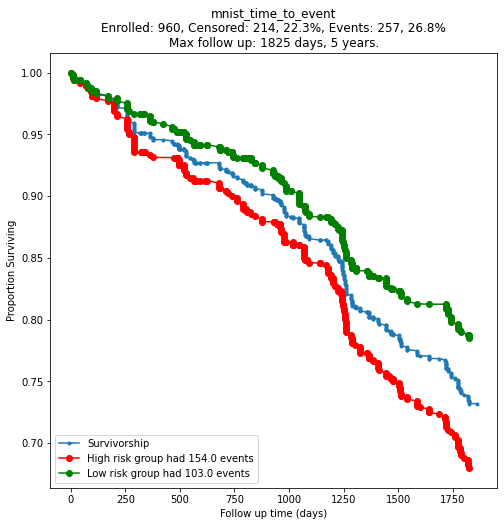

In [12]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_time_to_event',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '30',
            '--batch_size', '32',
            '--epochs', '1',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_time_to_event'
           ]
args = parse_args()
train_multimodal_multitask(args)

![./runs/mnist_time_to_event/survivorship_fu_1825_mnist_time_to_event.png](./runs/mnist_time_to_event/survivorship_fu_1825_mnist_time_to_event.png)

In [13]:
def mnist_invert_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    if label > 6:
        tensor[0] = 1.0 if np.random.rand() > 0.95 else 0.0
    elif label > 3:
        tensor[0] = 1.0 if np.random.rand() > 0.5 else 0.0
    elif label > 1:
        tensor[0] = 1.0 if np.random.rand() > 0.1 else 0.0    
    else:
        tensor[0] = 1.0 if np.random.rand() > 0.01 else 0.0
    tensor[1] = 1+label* np.random.randint(1, 365)
    return tensor
    
TMAPS['mnist_time_to_event_invert'] = TensorMap('mnist_time_to_event_invert', Interpretation.TIME_TO_EVENT, 
                                         tensor_from_file=mnist_invert_label_as_time_to_event)

2020-06-08 12:03:28,088 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./runs/mnist_time_to_event_invert/log_2020-06-08_12-03_0.log.
2020-06-08 12:03:28,090 - arguments:375 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_time_to_event_invert --training_steps 64 --validation_steps 24 --test_steps 32 --batch_size 64 --epochs 32 --eager --output_folder ./runs/ --id mnist_time_to_event_invert

2020-06-08 12:03:28,091 - arguments:376 - INFO - Total TensorMaps: 582 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=64, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size

2020-06-08 12:03:32,078 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-06-08 12:03:32,343 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 64 steps, validate for 24 steps
Epoch 1/32
63/64 [============================>.] - ETA: 0s - loss: 1.7382
Epoch 00001: val_loss improved from inf to 1.77599, saving model to ./runs/mnist_time_to_event_invert/mnist_time_to_event_invert.h5
64/64 [==============================] - 12s 186ms/step - loss: 1.7448 - val_loss: 1.7760
Epoch 2/32
63/64 [============================>.] - ETA: 0s - loss: 1.7765
Epoch 00002: val_loss improved from 1.77599 to 1.74212, saving model to ./runs/mnist_time_to_event_invert/mnist_time_to_event_invert.h5
64/64 [==============================] - 11s 166ms/step - loss: 1.7772 - val_loss: 1.7421
Epoch 3/32
63/64 [============================>.] - ETA: 0s - loss: 1.6325
Epoch 00003: val_loss improved from 1.74212 to 1.62815, saving model

Epoch 26/32
 4/64 [>.............................] - ETA: 8s - loss: 1.62062020-06-08 12:07:50,992 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ train_worker completed true epoch 3 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 34927 paths. Epoch: 3
	11642 tensors were presented.
	0 paths were skipped because they previously failed.
	The following errors occurred:
		
63/64 [============================>.] - ETA: 0s - loss: 1.5517
Epoch 00026: val_loss did not improve from 1.47280
64/64 [==============================] - 10s 157ms/step - loss: 1.5519 - val_loss: 1.5095
Epoch 27/32
63/64 [============================>.] - ETA: 0s - loss: 1.54332020-06-08 12:08:10,050 - tensor_generators:186 - INFO - 
!>~~~~~~~~~~~~ validation_worker completed true epoch 5 ~~~~~~~~~~~~<!
Aggregated information string:
	Generator looped & shuffled over 10085 paths. Epoch: 5
	2017 tensors were presented.
	0 paths were skipped because they previously failed.
	The following

{'mnist_time_to_event_invert_C_Index_0.796_vs_ROC': 0.8498908424055422}

<Figure size 1152x1152 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x1152 with 0 Axes>

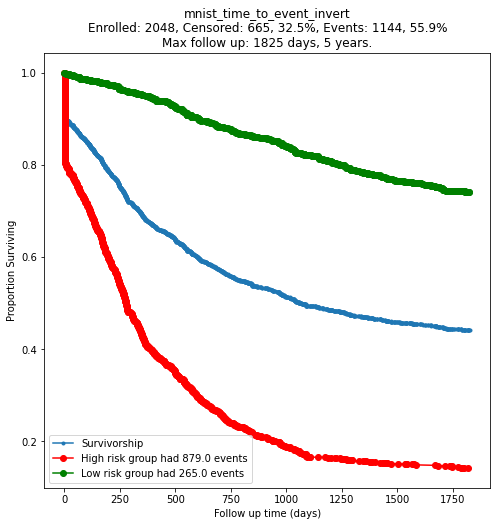

In [14]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_time_to_event_invert',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '32',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_time_to_event_invert'
           ]
args = parse_args()
train_multimodal_multitask(args)

In [15]:
def mnist_oscillate_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    if label % 2 == 0:
        tensor[0] = 1.0 if np.random.rand() > 0.98 else 0.0
        tensor[1] = 1+label* np.random.randint(1, 3650)
    else:
        tensor[0] = 1.0 if np.random.rand() > 0.02 else 0.0
        tensor[1] = 1+label* np.random.randint(1, 365)
    return tensor
    
TMAPS['mnist_oscillate_label_as_time_to_event'] = TensorMap('mnist_oscillate_label_as_time_to_event', Interpretation.TIME_TO_EVENT, 
                                         tensor_from_file=mnist_oscillate_label_as_time_to_event)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_oscillate_label_as_time_to_event',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '28',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_oscillate_label_as_time_to_event'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-06-08 12:09:06,565 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./runs/mnist_oscillate_label_as_time_to_event/log_2020-06-08_12-09_0.log.
2020-06-08 12:09:06,566 - arguments:375 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_oscillate_label_as_time_to_event --training_steps 64 --validation_steps 24 --test_steps 32 --batch_size 64 --epochs 28 --eager --output_folder ./runs/ --id mnist_oscillate_label_as_time_to_event

2020-06-08 12:09:06,568 - arguments:376 - INFO - Total TensorMaps: 583 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=64, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckTyp

2020-06-08 12:09:10,697 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-06-08 12:09:10,853 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 64 steps, validate for 24 steps
Epoch 1/28
63/64 [============================>.] - ETA: 0s - loss: 1.6437

In [ ]:
def mnist_label_as_survival_curve(tm, hd5, dependents={}):
    label = float(hd5['mnist_label'][0])
    has_disease = 1.0 if np.random.rand() > (label / 10) else 0.0
    days_follow_up = np.random.randint(1, 3650)
        
    intervals = int(tm.shape[0] / 2)
    days_per_interval = tm.days_window / intervals
    survival_then_censor = np.zeros(tm.shape, dtype=np.float32)
    for i, day_delta in enumerate(np.arange(0, tm.days_window, days_per_interval)):
        survival_then_censor[i] = float(day_delta < days_follow_up)
        if day_delta <= days_follow_up < day_delta + days_per_interval:
            survival_then_censor[intervals+i] = has_disease
    return survival_then_censor
    
TMAPS['mnist_survival_curve'] = TensorMap('mnist_survival_curve', Interpretation.SURVIVAL_CURVE, shape=(50,),
                                         tensor_from_file=mnist_label_as_survival_curve)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_survival_curve',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '16',
            '--learning_rate', '0.02',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_label_as_survival_curve'
           ]
args = parse_args()
train_multimodal_multitask(args)

In [ ]:
def mnist_survival_curve_convex(tm, hd5, dependents={}):
    label = float(hd5['mnist_label'][0])
    has_disease = 1.0 if np.random.rand() > (label / 10) else 0.0
    days_follow_up = np.random.randint(1, label*365)
        
    intervals = int(tm.shape[0] / 2)
    days_per_interval = tm.days_window / intervals
    survival_then_censor = np.zeros(tm.shape, dtype=np.float32)
    for i, day_delta in enumerate(np.arange(0, tm.days_window, days_per_interval)):
        survival_then_censor[i] = float(day_delta < days_follow_up)
        if day_delta <= days_follow_up < day_delta + days_per_interval:
            survival_then_censor[intervals+i] = has_disease
    return survival_then_censor
    
TMAPS['mnist_survival_curve_convex'] = TensorMap('mnist_survival_curve_convex', Interpretation.SURVIVAL_CURVE, shape=(50,),
                                         tensor_from_file=mnist_survival_curve_convex)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_survival_curve_convex',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '4',
            '--learning_rate', '0.02',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_label_as_survival_curve_convex'
           ]
args = parse_args()
train_multimodal_multitask(args)

In [ ]:
def mnist_survival_curve_elbow(tm, hd5, dependents={}):
    label = float(hd5['mnist_label'][0])
    has_disease = 1.0 if np.random.rand() > (label / 20) else 0.0
    days_follow_up = np.random.randint(1, 4650) if np.random.rand() > ((10-label) / 10) else np.random.randint(901, 2000)
        
    intervals = int(tm.shape[0] / 2)
    days_per_interval = tm.days_window / intervals
    survival_then_censor = np.zeros(tm.shape, dtype=np.float32)
    for i, day_delta in enumerate(np.arange(0, tm.days_window, days_per_interval)):
        survival_then_censor[i] = float(day_delta < days_follow_up)
        if day_delta <= days_follow_up < day_delta + days_per_interval:
            survival_then_censor[intervals+i] = has_disease
    return survival_then_censor
    
TMAPS['mnist_survival_curve_elbow'] = TensorMap('mnist_survival_curve', Interpretation.SURVIVAL_CURVE, shape=(50,),
                                         tensor_from_file=mnist_survival_curve_elbow)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_survival_curve_elbow',
            '--training_steps', '72',
            '--validation_steps', '24',
            '--test_steps', '36',
            '--batch_size', '64',
            '--epochs', '8',
            '--learning_rate', '0.01',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_label_as_survival_curve_elbow'
           ]
args = parse_args()
train_multimodal_multitask(args)